# Training a multi-linear classifier with a two layer network** 

*Herein I trained and tested a two layer network with multiple outputs to classify images from the CIFAR-10 dataset. I trained the network by using mini-batch gradient descent applied to a cost function that computes the cross-entropy loss of the classifier applied to the labelled training data and a L2 regularization term on the weight matrix.*

In [0]:
#@title Installers
# !pip uninstall -y scipy
# !pip install scipy==1.2.0
# !pip install texttable

In [0]:
#@title Import libraries
#Import CIFAR-10 data from my google drive folder; I downoaded and unzipped the CIRAR-10 files and uploaded them to my drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
import pandas
import unittest
import numpy
import statistics
from texttable import Texttable
from sklearn.preprocessing import StandardScaler
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

from PIL import Image
import pickle
import numpy as np
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

import io
from googleapiclient.http import MediaIoBaseDownload
import matplotlib.pyplot as plt

from scipy import misc #remove, using PIL instead

In [0]:
#@title Functions: Decoding and displaying images
def unpickle(file):
  dict = pickle.load(file, encoding='bytes')
  return dict

def unpickle_getFromDrive(file_id):
  filename = GetFromDrive(file_id)
  dict = pickle.load(filename, encoding='bytes')
  return dict 

def loadLabels(file_id):
  data = unpickle_getFromDrive(file_id)
  labels = [x.decode('ascii') for x in data[b'label_names']]
  return labels

def load_batch(file_id):
    filename = GetFromDrive(file_id)
    dataDict = unpickle(filename)
    X = (dataDict[b"data"]).T
    X = (X - np.mean(X, axis=1, keepdims=True) ) / np.std(X, axis=1, keepdims=True) #transform to have zero mean
    y = np.array(dataDict[b"labels"])
    Y = (np.eye(10)[y]).T   
    return X, Y, y

def GetFromDrive(file_id): 
    request = drive_service.files().get_media(fileId=file_id)
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    done = False
    while done is False:
      _, done = downloader.next_chunk()
    downloaded.seek(0)
    return downloaded


*Read in the data & initialize the parameters of the network*

Next, I will just use the data in the file data_batch_1 for training, the file data_batch_2 for validation and the file test_batch for testing. Also, transform it to have zero mean and normalize it.

In [0]:
#@title Functions: Load data_batches (1, 2 and test) for training, validation and test
def trainOnSmallDataBatch(samples=-1):
    X_train, Y_train, y_train = \
        load_batch('1M6-KBxAaqIqy9ekv3vhBlcTd3g1rkFcw') # data_batch_1
    X_val, Y_val, y_val = \
        load_batch('155Iy6tGX9HkNgZSdTPc9qGg9HCfay-Fy') # data_batch_2
    X_test, Y_test, y_test = \
        load_batch('1HdB9Dv2I9y1K-qcb__9M7Za0ZNtU1aIy') # test_batch

    labels = loadLabels('18LLg8Ch3GkdXI0MRAcoSwTzPKdgJMOQv') # labels

    if samples > -1:
      d = 5 #X_train.shape[0]
      data = {
          'X_train': X_train[:samples, :d],
          'Y_train': Y_train[:samples, :d],
          'y_train': y_train,
          'X_val': X_val[:samples, :d],
          'Y_val': Y_val[:samples, :d],
          'y_val': y_val,
          'X_test': X_test[:samples, :d],
          'Y_test': Y_test[:samples, :d],
          'y_test': y_test
      }
    elif samples == -1:
          data = {
          'X_train': X_train,
          'Y_train': Y_train,
          'y_train': y_train,
          'X_val': X_val,
          'Y_val': Y_val,
          'y_val': y_val,
          'X_test': X_test,
          'Y_test': Y_test,
          'y_test': y_test
      }

    return data, labels

In [0]:
#@title Functions: Initialize network parameters
class NetClassifier():
    def __init__(self, data, labels, M=50, W1=None, b1=None, W2=None, b2=None):
        self.M = M
        self.labels = labels

        for a, b in data.items():
            setattr(self, a, b)

        N = self.X_train.shape[1]
        D = self.X_train.shape[0]
        C = len(self.labels)
        self.W1 = np.random.normal(0, 1/np.sqrt(D), (M, D)) 
        self.b1 = np.zeros((M, 1))
        self.W2 = np.random.normal(0, 1/np.sqrt(M), (C, M))
        self.b2 = np.zeros((C, 1))

    def init_parameters(self, Ws, bs):
        params = {}
        for b_n, b_sh in bs.items():
            params[b_n] = np.zeros(b_sh)

        for W_n, W_sh in Ws.items():
            params[W_n] = np.random.normal(0, 1/np.sqrt(W_sh[1]), W_sh)

        return params

The following function (Evalute Classifier, Cost and Accuracy) is from my previous assignment, however, they have been altered in small extent to consider new features of this assignment

In [0]:
#@title Functions: Evaluate Classifier, Cost and Accuracy
class EvaluationFunctions(NetClassifier):
    @staticmethod
    def SoftMax(a):
        sm = np.exp(a - np.max(a, axis=0)) / \
                np.exp(a - np.max(a, axis=0)).sum(axis=0)
        return sm

    @staticmethod
    def Relu(a):
        a[a<0] = 0
        return a

    def EvaluateClassifier(self, X):
        h = self.Relu(self.b1+self.W1@X )
        p = self.SoftMax(self.b2+self.W2@h)
        return h, p

    def ComputeAccuracy(self, X, y):
        argMaxP = np.argmax(self.EvaluateClassifier(X)[1], axis=0)
        acc = argMaxP.T[argMaxP == np.asarray(y)].shape[0] / X.shape[1]
        return acc

    def ComputeCost(self, X, Y, lamda):
        N = X.shape[1]
        _, P = self.EvaluateClassifier(X)
        loss = 1/N * - np.sum(Y*np.log(P))
        cost = loss + lamda * (np.sum(self.W1**2) + np.sum(self.W2**2))
        return loss, cost

In the following the network parameters are intialized wherein M=50 (number of hidden layers), bias vectors are set to zero and entries in the weight matrices are random draws from a Gaussion ditribution with mean 0 and standard deviation of 1/sqrt(d) for layer 1 and 1/sqrt(m) for layer 2.

In [0]:
data, labels = trainOnSmallDataBatch() #load data
clf = NetClassifier(data, labels) #initialize network parameters

*Compute the gradients for the network parameters*

Next, the functions to compute the gradients (copied and altered from my first assignment) of my two-layer network w.r.t. its weight and bias parameters.  

In [0]:
#@title Functions: Compute & Compare Gradients Methods
class ComputeGradients(EvaluationFunctions):
    def ComputeGradientsAnalytically(self, X_batch, Y_batch, lamda):
        h, p  = self.EvaluateClassifier(X_batch) #Forward
        g = - (Y_batch - p) #Backward
        N = X_batch.shape[1]
        grad_W2 = 2 * self.W2 *lamda + 1/N * g@h.T   
        grad_b2 = np.reshape(1/N * g@np.ones(N), (Y_batch.shape[0], 1))
        g = self.W2.T@g
        h[h <= 0] = 0
        g = np.multiply(g, h > 0)
        grad_W1 = self.W1 * lamda + 1/N * g@X_batch.T 
        grad_b1 = np.reshape(1/N * g@np.ones(N), (self.M, 1))

        return grad_W1, grad_b1, grad_W2, grad_b2

    def ComputeGradientsNum(self, X_batch, Y_batch, lamda=0, h=1e-7):
        grads = {}
        for x in [1,2]:
            sW = getattr(self, 'W' + str(x))
            sb = getattr(self, 'b' + str(x))
            grads['W' + str(x)] = np.zeros(sW.shape)
            grads['b' + str(x)] = np.zeros(sb.shape)

            for i in range(sb.shape[0]):
                sb = np.copy(sb)[:]
                sb[x] = sb[x] + h
                _, cc2 = self.ComputeCost(X_batch, Y_batch, lamda)
                getattr(self, 'b' + str(x))[i] = getattr(self, 'b' + str(x))[i] - 2*h
                _, cc3 = self.ComputeCost(X_batch, Y_batch, lamda)
                grads['b' + str(x)][i] = (cc2-cc3) / (2*h)

            for i in np.ndindex(sW.shape):
                sW = np.copy(sW)[:,:]
                sW[i] = sW[i] + h
                _, cc2 = self.ComputeCost(X_batch, Y_batch, lamda)
                getattr(self, 'W' + str(x))[i] = getattr(self, 'W' + str(x))[i] - 2*h
                _, cc3 = self.ComputeCost(X_batch, Y_batch, lamda)
                grads['W' + str(x)][i] = (cc2-cc3) / (2*h)
        return grads['W1'], grads['b1'], grads['W2'], grads['b2']
    
    def absErr(self, grad1, grad2):
        abs_err = np.abs(grad1 - grad2) 
        return abs_err*100*100*100

    def CompareGradients(self, X_batch, Y_batch, lamda):

        grad_W1, grad_b1, grad_W2, grad_b2 = self.ComputeGradientsAnalytically(
            X_batch, Y_batch, lamda)

        grad_W1_num, grad_b1_num, grad_W2_num, grad_b2_num = self.ComputeGradientsNum(
            X_batch, Y_batch, lamda)

        err = Texttable()
        err_data = [] 

        # Compare accurate numerical method with analytical estimation of gradient
        err_data.append(['Gradient', 'Method',  'Abs Diff Mean [e-06]'])

        cdm_err_W1_abs = self.absErr(grad_W1, grad_W1_num) 
        cdm_err_b1_abs = self.absErr(grad_b1, grad_b1_num)
        cdm_err_W2_abs = self.absErr(grad_W2, grad_W2_num)
        cdm_err_b2_abs = self.absErr(grad_b2, grad_b2_num)

        err_data.append(["W1", "ANL vs NUM", str(np.mean(cdm_err_W1_abs))])
        err_data.append(["b1", "ANL vs NUM", str(np.mean(cdm_err_b1_abs))])
        err_data.append(["W2", "ANL vs NUM", str(np.mean(cdm_err_W2_abs))])
        err_data.append(["b2", "ANL vs NUM", str(np.mean(cdm_err_b2_abs))])

        err.add_rows(err_data)
        print("Method Comparison: Analytical vs Numerical")
        print(err.draw())      

The following generates the gradient comparing result that shows that the implemented analytical gradient method is close enough to be regarded as accurate.

In [0]:
#@title Compare Analytical with Numerical Gradient
data, labels = trainOnSmallDataBatch(100) #much smaller sample space
clf = ComputeGradients(data, labels)
clf.CompareGradients(data['X_train'], data['Y_train'], 0.0)


Method Comparison: Analytical vs Numerical
+----------+------------+----------------------+
| Gradient |   Method   | Abs Diff Mean [e-06] |
+==========+============+======================+
| W1       | ANL vs NUM | 0.138                |
+----------+------------+----------------------+
| b1       | ANL vs NUM | 0.002                |
+----------+------------+----------------------+
| W2       | ANL vs NUM | 1.337                |
+----------+------------+----------------------+
| b2       | ANL vs NUM | 0.232                |
+----------+------------+----------------------+


*Train the network with cyclical learning rates*

To avoid time-consuming searches for good values of eta, I have implemented mini-batch gradient descent training were the learning rate at each update step is pre-defined and eta_min is set to 1e-5, eta_max to 1e-1 and n_s=500 and batch size to 100. t should be run from 1 to 2*n_s and lambda=0.01.

The figure that the following training produces corresponds shows the cost, loss and accuracy for one cycle training. Accuracy achieved on the test set is 62.1% and validation set 45.4%


In [0]:
#@title Functions: Compute Mini Batch Gradient Descent
class MBGradientDescent(ComputeGradients):    
    def MiniBatchGD(self, X, Y, lamda=0, batch_s=100, eta_min=1e-5,
        eta_max=1e-1, n_s = 800, n_epochs=40, plot=False):
      
      n_batch = int(np.floor(X.shape[1] / batch_s))
      eta = eta_min
      t = 0

      if plot:
          costs_tr, loss_tr, acc_tr, costs_val, loss_val, acc_val = \
                  np.zeros(n_epochs), np.zeros(n_epochs), np.zeros(n_epochs), \
                  np.zeros(n_epochs), np.zeros(n_epochs), np.zeros(n_epochs)

      for n in range(n_epochs):
          for j in range(n_batch):
              N = int(X.shape[1] / n_batch)
              j_start = (j) * N
              j_end = (j+1) * N

              X_batch = X[:, j_start:j_end]
              Y_batch = Y[:, j_start:j_end]

              grad_W1, grad_b1, grad_W2, grad_b2 = self.ComputeGradientsAnalytically(
                      X_batch, Y_batch, lamda)
              self.W1 -= eta * grad_W1
              self.W2 -= eta * grad_W2
              self.b1 -= eta * grad_b1
              self.b2 -= eta * grad_b2

              if t <= n_s: eta = eta_min + t/n_s * (eta_max - eta_min)
              elif t <= 2*n_s: eta = eta_max - (t - n_s)/n_s * (eta_max - eta_min)
              t = (t+1) % (2*n_s)

          if plot:
              loss_tr[n], costs_tr[n] = self.ComputeCost(X, Y, lamda)
              loss_val[n], costs_val[n] = self.ComputeCost(
                      self.X_val, self.Y_val, lamda)
              acc_tr[n] = self.ComputeAccuracy(self.X_train, self.y_train)
              acc_val[n] = self.ComputeAccuracy(self.X_val, self.y_val)

      if plot:
          self.PlotFigure(n_epochs, costs_tr, costs_val, "cost",y_label="cost", y_max=4.5)
          self.PlotFigure(n_epochs, loss_tr, loss_val, "loss",y_label="loss", y_max=3.0)
          self.PlotFigure(n_epochs, acc_tr, acc_val, "accuracy",y_label="accuracy", y_max=1.0)

      acc_train = self.ComputeAccuracy(self.X_train, self.y_train)
      acc_val   = self.ComputeAccuracy(self.X_val, self.y_val)
      acc_tst  = self.ComputeAccuracy(self.X_test, self.y_test)

      return acc_train, acc_val, acc_tst

    def PlotFigure(self, n_epochs, i_train, i_val, title, y_label, y_max=4):
          epochs = np.arange(n_epochs)
          fig, ax = plt.subplots(figsize=(8, 6))
          ax.plot(epochs, i_val, 'r-', label="validation")
          ax.plot(epochs, i_train, 'g-', label="training")
          ax.legend()
          ax.set(xlabel='epochs', ylabel=y_label)
          ax.set_ylim([0, y_max])
          ax.grid()

    def PlotTable(self, acc_train, acc_val,acc_test):
          t = Texttable()
          dd = [] 
          dd.append(['Train Accuracy', 'Val Accuracy', 'Test Accuracy'])
          dd.append([acc_train, acc_val,acc_test])
          t.add_rows(dd)
          print("**********************************************")
          print(t.draw())
          print(" ")               

**********************************************
+----------------+--------------+---------------+
| Train Accuracy | Val Accuracy | Test Accuracy |
+================+==============+===============+
| 0.615          | 0.457        | 0.456         |
+----------------+--------------+---------------+
 


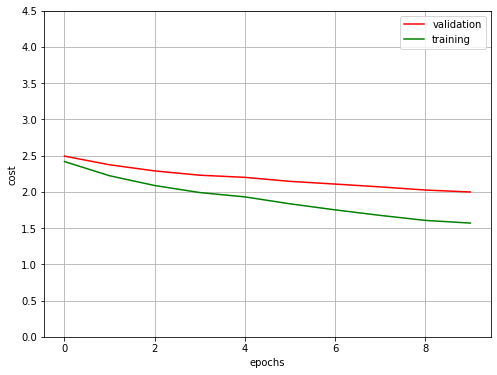

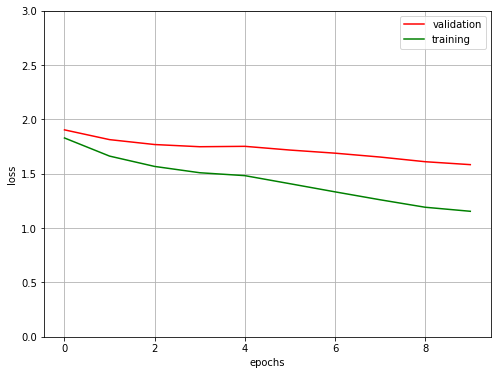

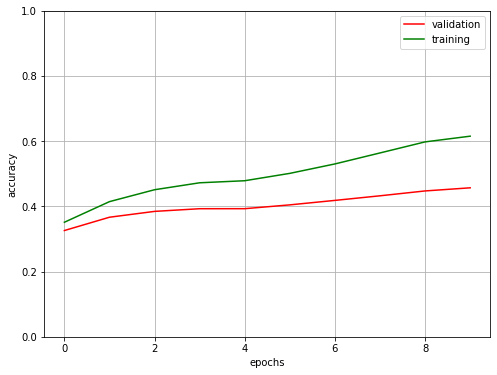

In [0]:
#@title Code: Trained network with One Cycle of Training Data
data, labels = trainOnSmallDataBatch() #load data
clf = MBGradientDescent(data, labels)
acc_train, acc_val,acc_test = clf.MiniBatchGD(data['X_train'], data['Y_train'], lamda=0.01,
        batch_s=100, eta_min=1e-5, eta_max=1e-1, n_s = 500,
        plot=True, n_epochs=10)
clf.PlotTable(acc_train, acc_val,acc_test)

Now, I will run with more cycles and larger n_s=800. In the following plots, it becomes clear that the loss and accuracy vary as the eta_t varies. Accuracy achieved on the test set is 78.4% and validation set 45.5%

**********************************************
+----------------+--------------+---------------+
| Train Accuracy | Val Accuracy | Test Accuracy |
+================+==============+===============+
| 0.785          | 0.449        | 0.445         |
+----------------+--------------+---------------+
 


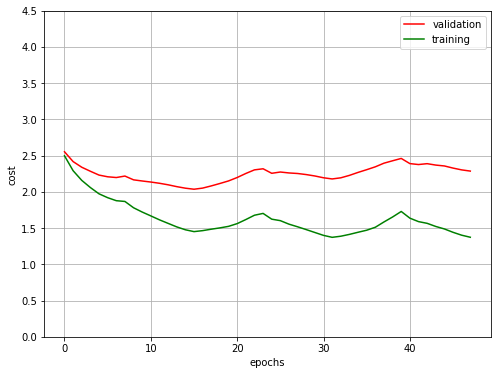

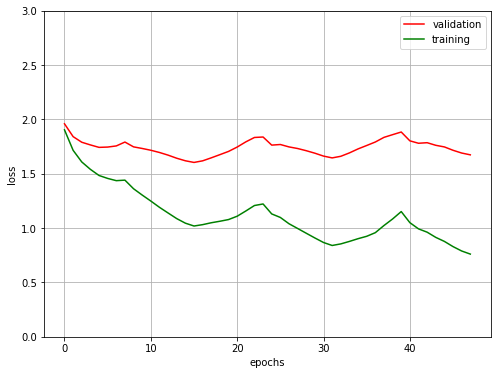

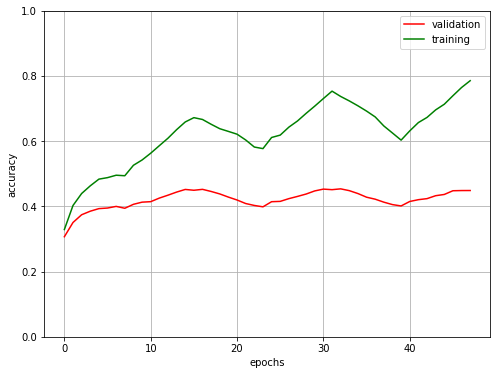

In [0]:
#@title Code: Trained network with Three Cycles of Training Data
data, labels = trainOnSmallDataBatch() #load data
clf = MBGradientDescent(data, labels)
acc_train, acc_val,acc_test = clf.MiniBatchGD(data['X_train'], data['Y_train'], lamda=0.01,
        batch_s=100, eta_min=1e-5, eta_max=1e-1, n_s = 800,
        plot=True, n_epochs=48)
clf.PlotTable(acc_train, acc_val,acc_test)

Next, I need to optimize the value of regularization term lambda. This is first done by performing a coarse random search and then a fine random search to set lambda.

**Coarse search**

This search is performed by running a random search through training my network on a random initalization and measuring the performance (via accuracy on the validation set) multiple times as the hyper-parameter lambda randomly varies. I will also extend the data to include the other batches and with more training data I expect to need a lower lambda. Thereby, the randomly selected lambdas will be close to zero. Moreover, 5,000 images will be used as my validation set. Training is with n_s=2*floor(n/n_batch) i.e. 2*floor(45,000/100)=900. Also I set the learning rate to eta_min=1e-5, eta_max=1e-1. 

In [0]:
#@title Functions: Load All Data
def trainOnAllDataBatches(val):
    X_train1, Y_train1, y_train1 = \
        load_batch('1M6-KBxAaqIqy9ekv3vhBlcTd3g1rkFcw')
    X_train2, Y_train2, y_train2 = \
        load_batch('155Iy6tGX9HkNgZSdTPc9qGg9HCfay-Fy')
    X_train3, Y_train3, y_train3 = \
        load_batch('10VIE8MElRqjIz0z-fIUX80OcWarKDdPp')
    X_train4, Y_train4, y_train4 = \
        load_batch('1ht7wULP6aOycu2J5F2zheesizftY2V2b')
    X_train5, Y_train5, y_train5 = \
        load_batch('1laJAlpuTD-YR_k9_rE0ZsSrbVApLaWgz')

    X_train = np.concatenate((X_train1, X_train2, X_train3, X_train4, X_train5),
            axis=1)
    Y_train = np.concatenate((Y_train1, Y_train2, Y_train3, Y_train4, Y_train5),
            axis=1)
    y_train = np.concatenate((y_train1, y_train2, y_train3, y_train4, y_train5))
    X_val = X_train[:, -val:]
    Y_val = Y_train[:, -val:]
    y_val = y_train[-val:]
    X_train = X_train[:, :-val]
    Y_train = Y_train[:, :-val]
    y_train = y_train[:-val]

    X_test, Y_test, y_test = \
        load_batch("1HdB9Dv2I9y1K-qcb__9M7Za0ZNtU1aIy")

    labels = loadLabels('18LLg8Ch3GkdXI0MRAcoSwTzPKdgJMOQv')
    
    data = {
        'X_train': X_train,
        'Y_train': Y_train,
        'y_train': y_train,
        'X_val': X_val,
        'Y_val': Y_val,
        'y_val': y_val,
        'X_test': X_test,
        'Y_test': Y_test,
        'y_test': y_test
    }

    return data, labels


In [0]:
#@title Functions: Train the Classifier on All Data
def searchForLambda(lamda_i, n_s_i, validationSet_i, n_epochs_i, batch_s_i, noTrainings, plot):
    data, labels = trainOnAllDataBatches(validationSet_i)

    acc_train_set = []
    acc_val_set = []
    acc_test_set = []
    for j in range(noTrainings):
      clf = MBGradientDescent(data, labels)
      acc_train, acc_val, acc_test = clf.MiniBatchGD(data['X_train'], data['Y_train'], lamda=lamda_i,
              batch_s=batch_s_i, eta_min=1e-5, eta_max=1e-1, n_s=n_s_i,n_epochs=n_epochs_i)

    acc_train_set.append(acc_train)
    acc_val_set.append(acc_val)
    acc_test_set.append(acc_test)

    train_mean_acc = str(statistics.mean(acc_train_set))
    val_mean_acc =  str(statistics.mean(acc_val_set))
    test_mean_acc = str(statistics.mean(acc_test_set))

    np.random.seed(0)
 
    if plot==1:
      clf = MBGradientDescent(data, labels)
      clf.MiniBatchGD(data['X_train'], data['Y_train'], lamda=lamda_i, 
                        batch_s=batch_s_i, 
                        eta_min=1e-5, 
                        eta_max=1e-1, 
                        n_s=n_s_i, 
                        plot=True, 
                        n_epochs = n_epochs_i)
    
    return train_mean_acc, val_mean_acc, test_mean_acc

def getResultsWhenTrainingForDifferentLambdas(validationSet, batch_s,n_s,n_epochs, nT, lambdas, title, plot):
    t = Texttable()
    data = [] 
    data.append(['Parameters', 'Train Accuracy', 'Val Accuracy', 'Test Accuracy'])

    for x in range(0, len(lambdas)):
      train_mean_acc, val_mean_acc, test_mean_acc = searchForLambda(lambdas[x], n_s, validationSet, n_epochs, batch_s, noTrainings = nT,plot=plot)
      saveFortbl = "lambda="+str(lambdas[x])
      data.append([saveFortbl,train_mean_acc, val_mean_acc,test_mean_acc])
      print("Lambda test done:" + str(lambdas[x]))
    t.add_rows(data)
    print("********************* "+title +" *************************")
    print("n epochs="+str(n_epochs)+", batch_s="+str(batch_s)+", n_s="+str(n_s)+"")
    print("*************************************************************")
    print(t.draw())
    print(" ")  

In the following coarse search I have randomly selected five very low regularzation terms. In the below resulting table it becomes clear that the validation accuracy is highest where lambda is below 0.01, thereby the fine search will be between this interval.

In [0]:
#@title Code: Coarse Search
validationSet = 5000
batch_s = 100
n_s = 2*np.floor((50000-validationSet)/batch_s) #900
n_epochs = 8
nT = 2
lambdas = [.001, .005, .01, .016, .02] #random selection of very low regularization

getResultsWhenTrainingForDifferentLambdas(validationSet, batch_s,n_s,n_epochs, nT, lambdas, "COARSE SEARCH", 0)

Lambda test done:0.001
Lambda test done:0.005
Lambda test done:0.01
Lambda test done:0.016
Lambda test done:0.02
********************* COARSE SEARCH *************************
n epochs=8, batch_s=100, n_s=900.0
*************************************************************
+--------------+----------------+--------------+---------------+
|  Parameters  | Train Accuracy | Val Accuracy | Test Accuracy |
+==============+================+==============+===============+
| lambda=0.001 | 0.590          | 0.521        | 0.508         |
+--------------+----------------+--------------+---------------+
| lambda=0.005 | 0.574          | 0.522        | 0.513         |
+--------------+----------------+--------------+---------------+
| lambda=0.01  | 0.556          | 0.514        | 0.513         |
+--------------+----------------+--------------+---------------+
| lambda=0.016 | 0.536          | 0.506        | 0.511         |
+--------------+----------------+--------------+---------------+
| lambda=0.02

The best fine search that yielded the highest accuracy on the validation set was at lambda=0.006 as is displayed in the table below. For future work, I would explore running a much wider random search. 

In [0]:
#@title Code: Fine Search
validationSet = 5000
batch_s = 100
n_s = 2*np.floor((50000-validationSet)/batch_s) #900
n_epochs = 12
nT = 2
lambdas = [.0055, .006, .0065, .007, .0084, .0089, .0093] #random selection of very low regularization between the coarse interval

getResultsWhenTrainingForDifferentLambdas(validationSet, batch_s,n_s,n_epochs, nT, lambdas, "FINE SEARCH", 0)

Lambda test done:0.0055
Lambda test done:0.006
Lambda test done:0.0065
Lambda test done:0.007
Lambda test done:0.0084
Lambda test done:0.0089
Lambda test done:0.0093
********************* FINE SEARCH *************************
n epochs=12, batch_s=100, n_s=900.0
*************************************************************
+---------------+----------------+--------------+---------------+
|  Parameters   | Train Accuracy | Val Accuracy | Test Accuracy |
+===============+================+==============+===============+
| lambda=0.0055 | 0.588          | 0.531        | 0.519         |
+---------------+----------------+--------------+---------------+
| lambda=0.006  | 0.585          | 0.537        | 0.523         |
+---------------+----------------+--------------+---------------+
| lambda=0.0065 | 0.583          | 0.525        | 0.521         |
+---------------+----------------+--------------+---------------+
| lambda=0.007  | 0.578          | 0.527        | 0.516         |
+---------------

The following is the best found lambda setting lambda=0.006, whereby all training data is used except for 1,000 example images in a validation set for approx. 3 cycles. The hyper-parameters used are lambda=0.006, batch_s=100, n_s=980 [2*np.floor((50000-1000)/batch_s)] and n_epochs equivalent to 3 cycles. Final accuracies are reported in the table below.

Lambda test done:0.006
********************* BEST CLASSIFIER *************************
n epochs=12, batch_s=100, n_s=980.0
*************************************************************
+--------------+----------------+--------------+---------------+
|  Parameters  | Train Accuracy | Val Accuracy | Test Accuracy |
+==============+================+==============+===============+
| lambda=0.006 | 0.584          | 0.540        | 0.521         |
+--------------+----------------+--------------+---------------+
 


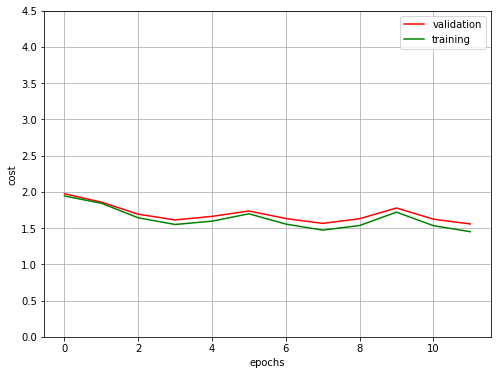

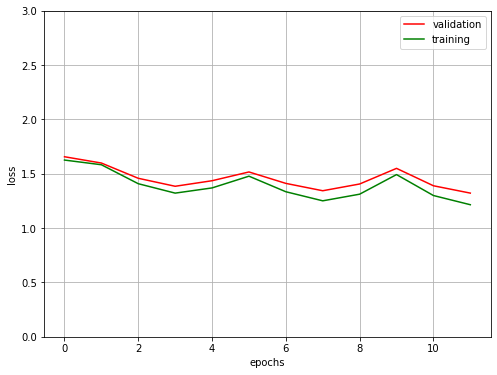

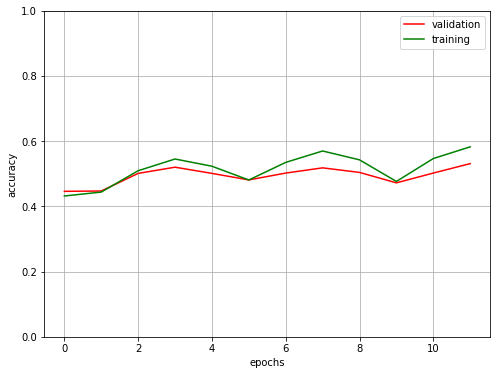

In [0]:
#@title Code: Best Classifier
validationSet = 1000
batch_s = 100
n_s = 2*np.floor((50000-validationSet)/batch_s) #980
n_epochs = 12
nT = 10
lambdas = [0.006] 
plot = 1

getResultsWhenTrainingForDifferentLambdas(validationSet, batch_s,n_s,n_epochs, nT, lambdas, "BEST CLASSIFIER", plot)